### Кредитный скоринг
Заказчиком поставлена задача обучить модель для работы кредитной системы, нужно провести предобработку полученных данных, веделить ключевые признаки, подобрать и обучить модели и сохранить лучшую модель для дальнейшего использования в API. Приоритетами являются высокая скорость обучения и предсказания, так же ключевой метрикой является recall

В полученных данных у нас есть следующие столбцы:  

id — уникальный идентификатор записи (строки).

customer_id — уникальный идентификатор клиента.

month — месяц, за который собраны данные (для временного анализа).

name — имя клиента.

age — возраст клиента (в годах).

ssn — номер социального страхования или аналогичный идентификатор личности.

occupation — род занятий клиента (инженер, врач, студент и т. д.).

annual_income — годовой доход клиента.

monthly_inhand_salary — средняя ежемесячная зарплата «на руки».

num_bank_accounts — количество банковских счетов клиента.

num_credit_card — количество кредитных карт у клиента.

interest_rate — средняя процентная ставка по активным кредитам.

num_of_loan — общее количество кредитов (ипотека, автокредит и т. д.).

type_of_loan — типы кредитов, которыми владеет клиент (возможен список через запятую).

delay_from_due_date — средняя задержка платежей в днях.

num_of_delayed_payment — количество просроченных платежей.

changed_credit_limit — изменение кредитного лимита (процент или сумма).

num_credit_inquiries — количество обращений в кредитную историю.

credit_mix — тип кредитного портфеля (например, “Good”, “Standard”, “Bad”).

outstanding_debt — общая сумма непогашенного долга.

credit_utilization_ratio — доля использованного кредитного лимита.

credit_history_age — возраст кредитной истории (например, “5 Years 3 Months”).

payment_of_min_amount — индикатор, платит ли клиент минимальный платеж (“Yes” / “No”).

total_emi_per_month — общая сумма ежемесячных выплат по кредитам (EMI).

amount_invested_monthly — средняя сумма ежемесячных инвестиций.

payment_behaviour — характеристика поведения по платежам (например, “High_spender”, “Regular_payer”).

monthly_balance — средний остаток на счету в конце месяца.

credit_score — итоговый кредитный рейтинг клиента (“Good”, “Standard”, “Poor”).

In [475]:
import pandas as pd
import numpy as np
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import make_scorer, fbeta_score
import joblib

In [476]:
credit_data_raw = pd.read_csv(r'E:/проекты/Проекты по DS/data/credit_scoring_data.csv')
print(credit_data_raw.shape)

(100000, 28)


C:\Users\Влад\AppData\Local\Temp\ipykernel_32244\3210884460.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  credit_data_raw = pd.read_csv(r'E:/проекты/Проекты по DS/data/credit_scoring_data.csv')


In [477]:
print(credit_data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [478]:
credit_data_raw.columns = credit_data_raw.columns.str.lower()
print(credit_data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        100000 non-null  object 
 1   customer_id               100000 non-null  object 
 2   month                     100000 non-null  object 
 3   name                      90015 non-null   object 
 4   age                       100000 non-null  object 
 5   ssn                       100000 non-null  object 
 6   occupation                100000 non-null  object 
 7   annual_income             100000 non-null  object 
 8   monthly_inhand_salary     84998 non-null   float64
 9   num_bank_accounts         100000 non-null  int64  
 10  num_credit_card           100000 non-null  int64  
 11  interest_rate             100000 non-null  int64  
 12  num_of_loan               100000 non-null  object 
 13  type_of_loan              88592 non-null   ob

Столбцы имеют не преавильное название, переименуем их

In [479]:
credit_data_raw.columns = credit_data_raw.columns.str.lower()
print(credit_data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        100000 non-null  object 
 1   customer_id               100000 non-null  object 
 2   month                     100000 non-null  object 
 3   name                      90015 non-null   object 
 4   age                       100000 non-null  object 
 5   ssn                       100000 non-null  object 
 6   occupation                100000 non-null  object 
 7   annual_income             100000 non-null  object 
 8   monthly_inhand_salary     84998 non-null   float64
 9   num_bank_accounts         100000 non-null  int64  
 10  num_credit_card           100000 non-null  int64  
 11  interest_rate             100000 non-null  int64  
 12  num_of_loan               100000 non-null  object 
 13  type_of_loan              88592 non-null   ob

In [480]:
print(credit_data_raw.head(5))

       id customer_id     month           name   age          ssn occupation annual_income  monthly_inhand_salary  num_bank_accounts  num_credit_card  interest_rate num_of_loan                                       type_of_loan  delay_from_due_date num_of_delayed_payment changed_credit_limit  num_credit_inquiries credit_mix outstanding_debt  credit_utilization_ratio     credit_history_age payment_of_min_amount  total_emi_per_month amount_invested_monthly                 payment_behaviour     monthly_balance credit_score
0  0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265  Scientist      19114.12            1824.843333                  3                4              3           4  Auto Loan, Credit-Builder Loan, Personal Loan,...                    3                      7                11.27                   4.0          _           809.98                 26.822620  22 Years and 1 Months                    No            49.574949       80.41529543900253   High_spent_Sm

Также некоторые столбцы имеют не верный тип данных

In [481]:
num_cols = ['annual_income', 'monthly_inhand_salary', 
            'outstanding_debt', 'monthly_balance', 'age',
              'num_of_loan', 'num_of_delayed_payment', 'amount_invested_monthly']


for col in num_cols:
    credit_data_raw[col] = pd.to_numeric(credit_data_raw[col], errors='coerce')

У нас есть неинформативные столбцы id и customer_id, удалим их датасета

In [482]:
credit_data_raw.drop(columns=['id', 'customer_id'], axis=1, inplace=True)

преобразуем столбец с целевой переменной в бинарные значения

In [483]:
credit_data_raw['credit_score'] = credit_data_raw['credit_score'].map({
     'Good': 1,
     'Standard': 1,
     'Poor': 0,
})

#### Поиск аномалий  

Проверим данные на наличие аномальных значений

In [484]:
def num_ditribution(data, xcols, titles, xlables, figsize, minus):
    fig, axs = plt.subplots(len(xcols), 2, figsize=figsize)
    for i in range(len(xcols)):
        sns.histplot(data=data, x=xcols[i], bins=30, ax=axs[i, 0])
        axs[i, 0].set_xlabel(xlables[i])
        axs[i, 0].set_ylabel('Количество')
        axs[i, 0].set_title(titles[i])

        sns.boxplot(x=data[xcols[i]], orient='h', ax=axs[i, 1])
        axs[i, 1].set_xlabel(xlables[i])
        axs[i, 1].set_title(titles[i])

    plt.subplots_adjust(wspace=0.3, hspace=0.9)
    plt.show()

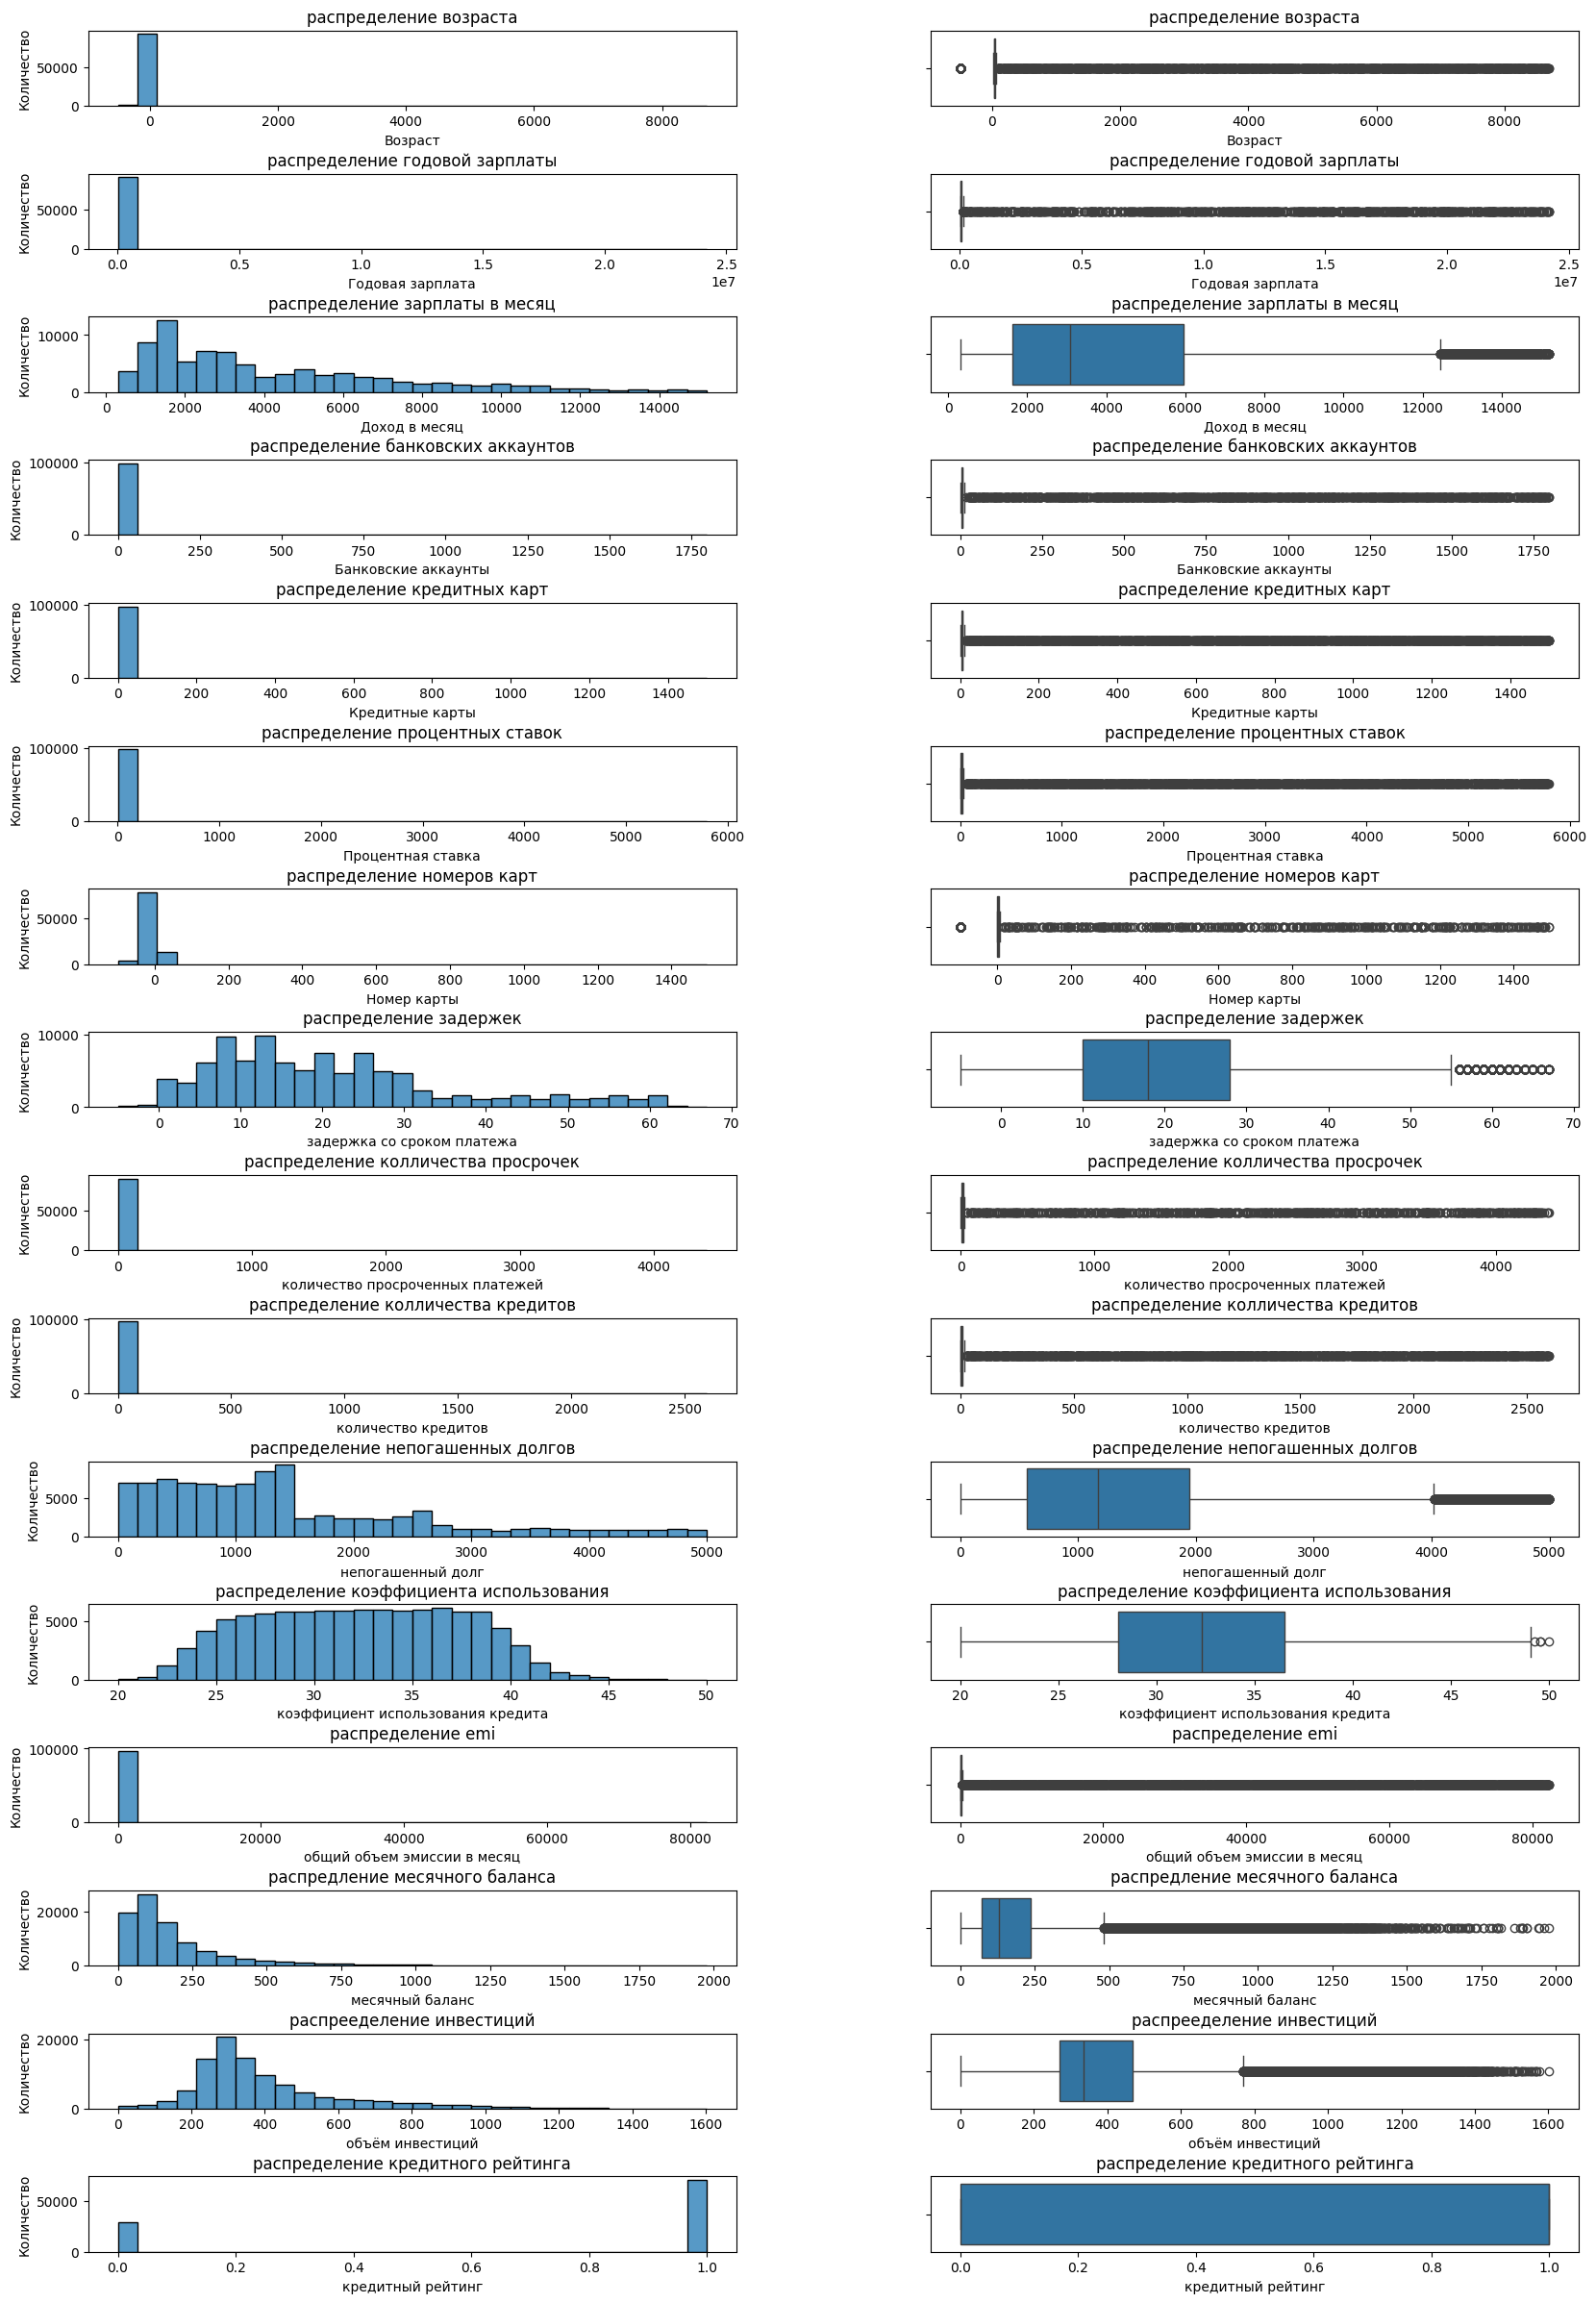

In [485]:
num_cols = [x for x in credit_data_raw.select_dtypes(include=['int64', 'float64'])]
credit_scores_xlabels = [
    'Возраст',
    'Годовая зарплата',
    'Доход в месяц',
    'Банковские аккаунты',
    'Кредитные карты',
    'Процентная ставка',
    'Номер карты',
    'задержка со сроком платежа',
    'количество просроченных платежей',
    'количество кредитов',
    'непогашенный долг',
    'коэффициент использования кредита',
    'общий объем эмиссии в месяц',
    'месячный баланс',
    'объём инвестиций',
    'кредитный рейтинг'
]

credit_titles = [
    'распределение возраста',
    'распределение годовой зарплаты',
    'распределение зарплаты в месяц',
    'распределение банковских аккаунтов',
    'распределение кредитных карт',
    'распределение процентных ставок',
    'распределение номеров карт',
    'распределение задержек',
    'распределение колличества просрочек',
    'распределение колличества кредитов',
    'распределение непогашенных долгов',
    'распределение коэффициента использования',
    'распределение emi',
    'распредление месячного баланса',
    'распрееделение инвестиций',
    'распределение кредитного рейтинга'
]

num_ditribution(credit_data_raw, num_cols, credit_titles, credit_scores_xlabels, (20, 30), 1)


В столбце **age** наблюдаются значения возраста меньше 0 и более 100, они являются выбросами поэтому их нужно исключить из выборки

В столбце **interest_rate** есть аномальные значения процентной ставки которые превышают 1000%, нужно свзяатсья с заказчиком и уточнить корректность данных, пока удалим эти значения  

В столбце **num_of_loan** есть значения меньше нуля, их нужно убрать из выборки

Есть экстремально высокие значения в признаках, показывающих колличество кредитов и просрочек, для принятия решения об удалении нужно будет провести корреляционный анализ

Распределение данных в столбце, показывающем распределение инвестиций, близко к нормальному сдвинутому немного в лево 

In [486]:
credit_data_raw = credit_data_raw[(credit_data_raw['age'] > 0) & (credit_data_raw['age'] < 85)]
credit_data_raw = credit_data_raw[credit_data_raw['interest_rate'] < 100]
credit_data_raw = credit_data_raw[credit_data_raw['num_of_loan'] > 0]

#### Пропуски в данных  

Проверим процент пропущенных значений в данных

In [487]:
print(credit_data_raw.isna().sum() / len(credit_data_raw) * 100)

month                        0.000000
name                        10.014058
age                          0.000000
ssn                          0.000000
occupation                   0.000000
annual_income                6.981315
monthly_inhand_salary       14.979459
num_bank_accounts            0.000000
num_credit_card              0.000000
interest_rate                0.000000
num_of_loan                  0.000000
type_of_loan                 0.072338
delay_from_due_date          0.000000
num_of_delayed_payment       9.691949
changed_credit_limit         0.000000
num_credit_inquiries         1.957225
credit_mix                   0.000000
outstanding_debt             1.015464
credit_utilization_ratio     0.000000
credit_history_age           9.034081
payment_of_min_amount        0.000000
total_emi_per_month          0.000000
amount_invested_monthly      8.817066
payment_behaviour            0.000000
monthly_balance              1.358047
credit_score                 0.000000
dtype: float

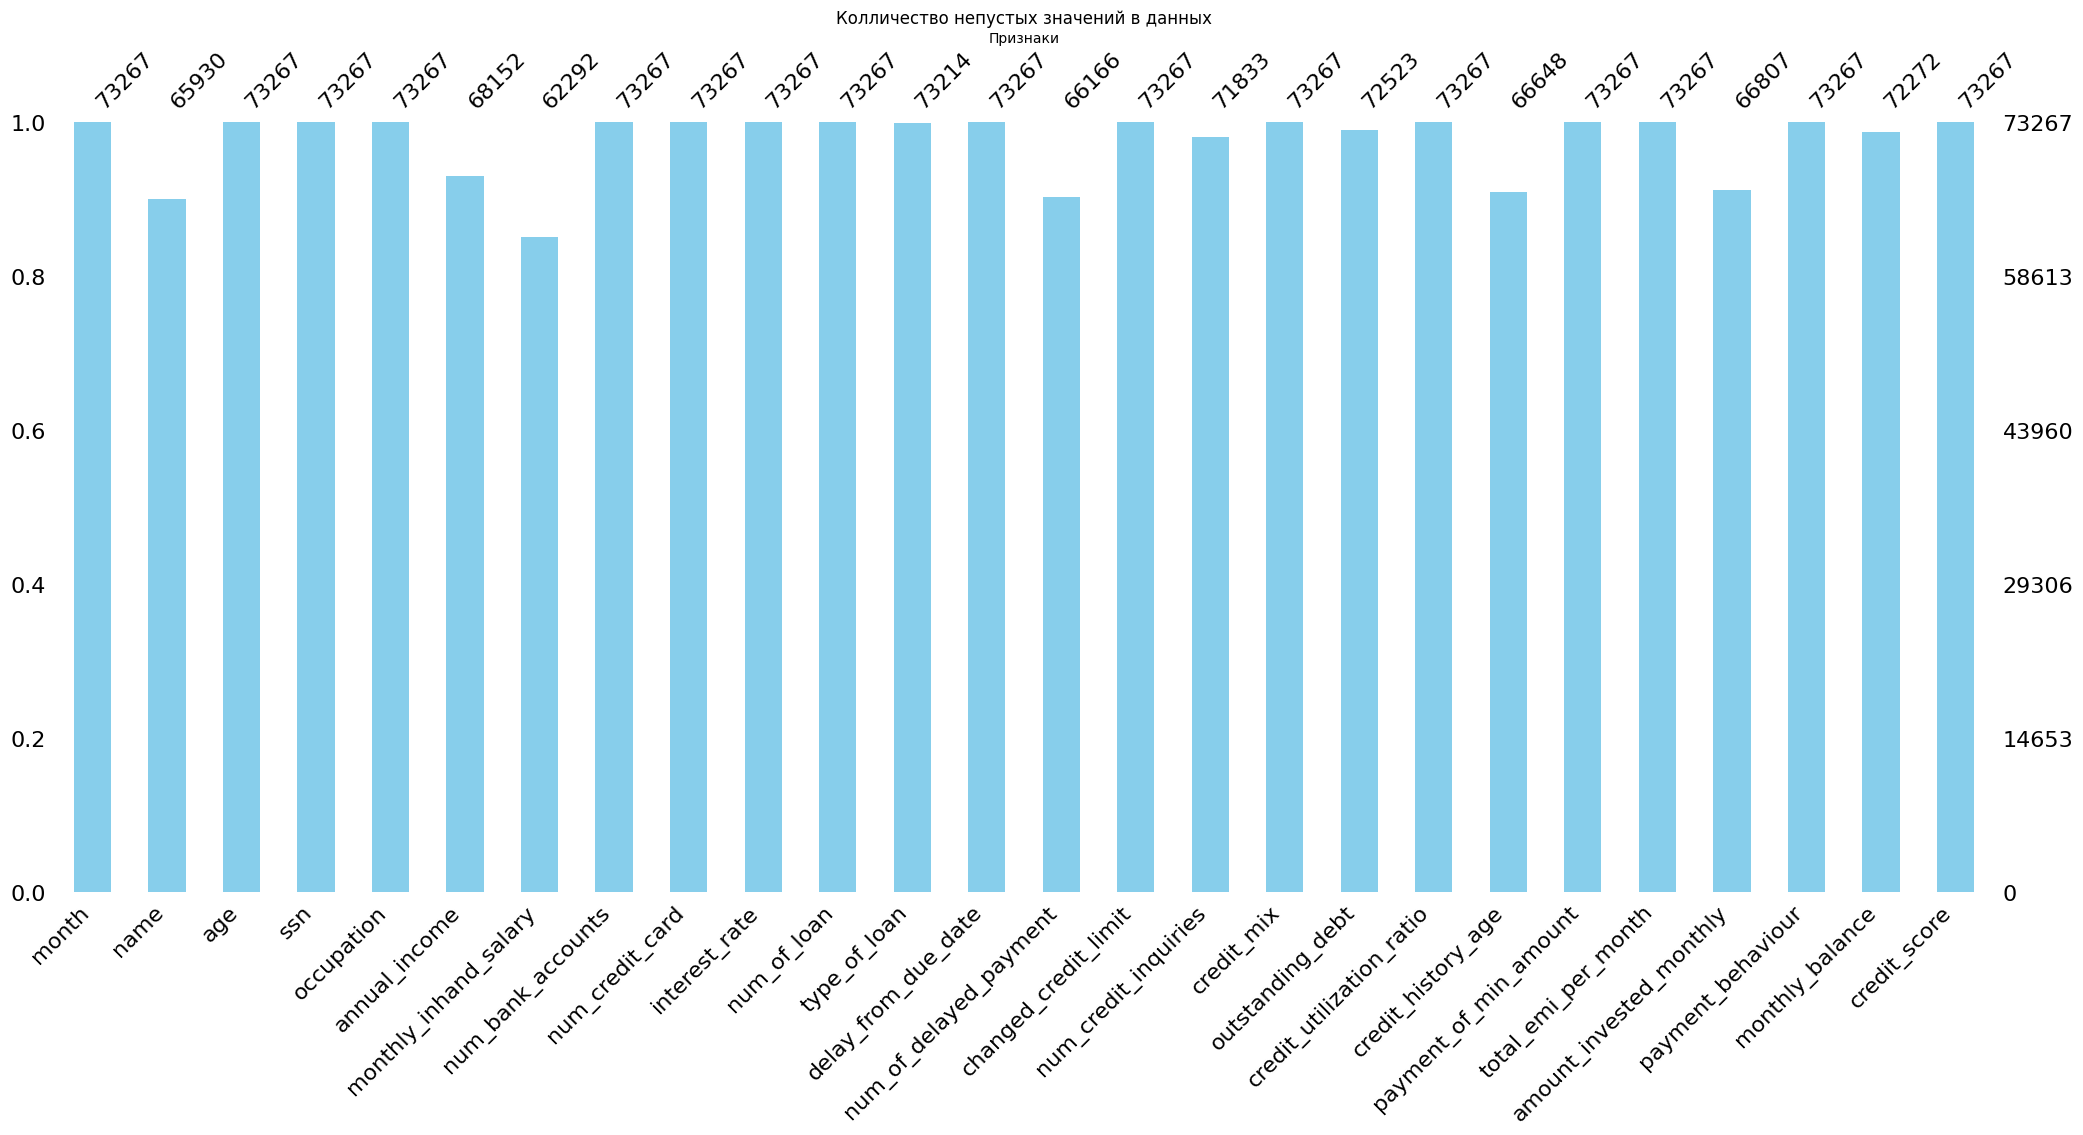

In [488]:
msno.bar(credit_data_raw, color='skyblue')
plt.title('Колличество непустых значений в данных')
plt.xlabel('Признаки')
plt.show()

На графике можно увидеть большое колличество пропусков в категоральном столбце **name**, заполнить данные будет довольно проблематично поэтому введём новую категорию Unknown.

Столбцы **annual_income**, **monthly_inhand_salary** так же имеют большое колличество пропусков, заполним их меданными значениями для этих столбцов остальные пропуски просто удалим

In [489]:
credit_data_raw['name'].fillna('unknown', inplace=True)
credit_data_raw['annual_income'].fillna(credit_data_raw['annual_income'].median(), inplace=True)
credit_data_raw['monthly_inhand_salary'].fillna(credit_data_raw['monthly_inhand_salary'].median(), inplace=True)
credit_data_raw.dropna(inplace=True)

C:\Users\Влад\AppData\Local\Temp\ipykernel_32244\4271292922.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  credit_data_raw['name'].fillna('unknown', inplace=True)
C:\Users\Влад\AppData\Local\Temp\ipykernel_32244\4271292922.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

#### Анализ дубликатов

In [490]:
credit_data_raw.duplicated().sum()

np.int64(0)

Теперь проверим данные на неявные дубликаты

In [491]:
for col in credit_data_raw.select_dtypes(include=['object']):
    print(f' {col}: {credit_data_raw[col].unique()}\n')

 month: ['January' 'April' 'June' 'February' 'March' 'May' 'July' 'August']

 name: ['Aaron Maashoh' 'Rick Rothackerj' 'Langep' ... 'Chris Wickhamm'
 'Sarah McBridec' 'Nicks']

 ssn: ['821-00-0265' '004-07-5839' '486-85-3974' ... '133-16-7738' '031-35-0942'
 '078-73-5990']

 occupation: ['Scientist' 'Teacher' '_______' 'Engineer' 'Entrepreneur' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Mechanic' 'Writer'
 'Accountant' 'Architect' 'Musician' 'Developer']

 type_of_loan: ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loan, Student Loan, Mortgage Loan, and Not Specified'
 'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan']

 changed_credit_limit: ['11.27' '6.27' '9.27' ... '12.670000000000002' '25.16' '20.08']

 credit_mix: ['_' 'Good' 'Standard' 'Bad']

 credit_history_age: ['22 Years and 1 M

В данных отсутвуют явные и не явные дубликаты

#### Корреляционный анализ  

построим матрицу корреляций для того чтобы оценить вляние данных на тагрет

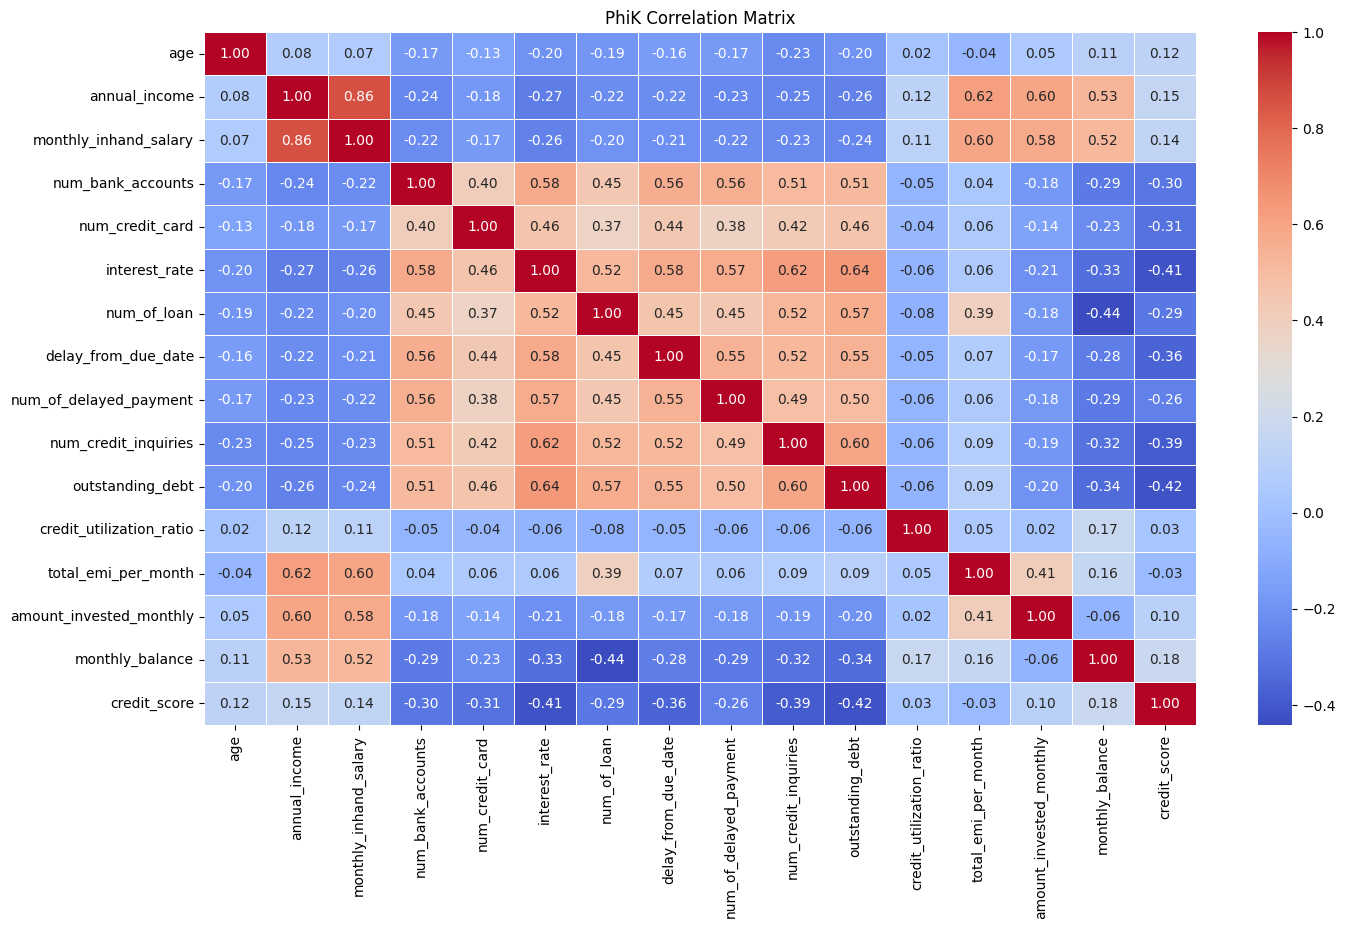

In [492]:
corr_matrix = credit_data_raw.corr(method='spearman', numeric_only=True)

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PhiK Correlation Matrix')
plt.show();

Признаки **total_emi_per_month**, **credit_utilization_ratio** почти не влиют на целевую переменную, их следует удалить из модели

Признаки **mount_invested_monthly**, **monthly_inhand_salary**, **num_bank_accounts**, **num_credit_cards**, **interest_rate**,**delay_from_due_date**, **num_credit_inquiries**, **outstanding_debt** мультиколлинеарны, следует выбрать один из них, который больше всего влияет на тагрег

In [493]:
credit_data_raw.drop(columns=['total_emi_per_month', 'credit_utilization_ratio', 'annual_income', 
                              'amount_invested_monthly','monthly_inhand_salary', 'num_bank_accounts', 
                              'num_credit_card', 'interest_rate', 'delay_from_due_date', 
                              'num_credit_inquiries','outstanding_debt', 'ssn', 'name', 'month'], inplace=True, axis=1)

In [494]:
credit_data = credit_data_raw

#### В результате загрузки данных и первичного анализа:

был загружен датасет **credit_data_raw**
были удалены аномальные значения в числовых столбцах  
обработаны пропущенные значения(так, в признаке name появилось значение 'unknown' вместо пропуска, в то время как остальные редко   встречающиеся пропуски были удалены из датасета)  
произведён корреляционный анализ, в результате которого были удалены неинформативные колонки  
все изменения были сохранены в **credit_data**  

#### Обучение и выбор моделей

Разделим данные на тренировочную и тестовую выборки

In [495]:
print(credit_data.columns)

Index(['age', 'occupation', 'num_of_loan', 'type_of_loan', 'num_of_delayed_payment', 'changed_credit_limit', 'credit_mix', 'credit_history_age', 'payment_of_min_amount', 'payment_behaviour', 'monthly_balance', 'credit_score'], dtype='object')


In [496]:
RANDOM_STATE = 42
X = credit_data.drop('credit_score', axis=1)
y = credit_data['credit_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [497]:
num_cols = ['age', 'num_of_loan', 'num_of_delayed_payment', 'monthly_balance']
ord_cols = ['type_of_loan', 'changed_credit_limit', 'credit_history_age']
ohe_cols = ['credit_mix','payment_of_min_amount', 'payment_behaviour', 'occupation']
cat_cols = X.select_dtypes(include=['object']).columns


Построим пайплайн для обработки категоральных типов данных

In [498]:
ohe_pipe = Pipeline([
    ('SimpleImputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'))
])

ord_pipe = Pipeline([
    ('Impute_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ('Impute_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

#### Построение и обучение моделей  

Заказчику важны скорость и полнота предсказния, так как моджель будет использвать для автоматизации выдачи кредитов, поэтому целособразно использовать метрику F2-score, которая оценивает recall в 4 раза больше чем precission  

первой моделью рассмотрим логистическую регресиию

In [499]:
f2_score = make_scorer(fbeta_score, beta=2)


data_preprosessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols),
    ('ord', ord_pipe, ord_cols),
    ('num', StandardScaler(), num_cols),
], remainder='drop')

log_pipe = Pipeline([
    ('preproseesor', data_preprosessor),
    ('log_reg', LogisticRegression(random_state=RANDOM_STATE, max_iter=5000, solver='lbfgs'))
])

In [500]:
log_f2 = cross_val_score(log_pipe, X_train, y_train, cv=5, scoring=f2_score).mean()

start_l = time.time()
log_pipe.fit(X_train, y_train)
end_l = time.time()

start_p = time.time()
log_pipe.predict(X_test)
end_p = time.time()

log_reg_stats = {
    'Время обучения': round(end_l - start_l, 3),
    'Время предсказания': round(end_p - start_p, 3),
    'F2-score': round(log_f2, 3)
}

for key, value in log_reg_stats.items():
    print(f'{key} {value}')

Время обучения 17.652
Время предсказания 0.093
F2-score 0.852


Модель показала хороший показатель метрики, но при этом она крайне долго обучается и довольньно долго предсказывает значения

Создадим функцию для добаления результатов обучения в словарь

In [501]:
def find_preprosessing_score(model):
    results_df = pd.DataFrame(model.cv_results_)
    best_scores_df = results_df[results_df['rank_test_score'] == 1]

    model_stats = {
        'Время обучения': round(best_scores_df['mean_fit_time'].iloc[0], 3),
        'Время предсказания': round(best_scores_df['mean_score_time'].iloc[0], 3),
        'F2-score': round(model.best_score_,3)
    }

    for key, value in model_stats.items():
        print(f'{key}: {value}')
    return model_stats

Теперь рассмотрим модель  **DecisionTreeClassifier** и сравним с полученными значениями для логистическолй регрессии

In [502]:

dtree_pipe = Pipeline([
    ('preprosessor', data_preprosessor),
    ('dtree', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [503]:
dtree_params_grid = {
    'dtree__max_depth': [3, 5, 7, 10, None],
    'dtree__min_samples_split': [2, 5, 10, 20],
    'dtree__min_samples_leaf': [1, 2, 5, 10]
}

In [504]:
dtree_search = GridSearchCV(
    dtree_pipe,
    dtree_params_grid,
    cv=5,
    scoring=f2_score,
    verbose=1
)

dtree_search.fit(X_train, y_train)
dtree_stats = find_preprosessing_score(dtree_search)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Время обучения: 0.423
Время предсказания: 0.095
F2-score: 0.896


In [525]:
print(dtree_search.best_params_)

{'dtree__max_depth': 3, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2}


Далее рассмотрим модель RandomForestClassifaer

In [505]:
rf_pipe = Pipeline([
    ('preprosessor', data_preprosessor),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [506]:
rf_param_grid = {
    'rf__n_estimators': [100, 300, 500],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 5]
}

In [507]:
rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring=f2_score,
    verbose=1
)

rf_search.fit(X_train, y_train)
rf_stats = find_preprosessing_score(rf_search)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Время обучения: 46.283
Время предсказания: 1.47
F2-score: 0.889


Далее обучим модель LGBMClassifier

In [508]:
lgbm_pipe = Pipeline([
    ('preprosessor', data_preprosessor),
    ('lgbm', LGBMClassifier())
])

In [ ]:
lgbm_params_grid = {
    'lgbm__n_estimators': [300, 500, 700, 800, 900, 1000],
    'lgbm__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}

X_train_lgbm = X_train.copy()
y_train_lgbm = y_train.copy()

In [ ]:
lgbm_search = GridSearchCV(
    lgbm_pipe,
    param_grid=lgbm_params_grid,
    cv=5,
    scoring=f2_score,
    verbose=1
)

lgbm_search.fit(X_train_lgbm, y_train_lgbm)
lgbm_stats = find_preprosessing_score(lgbm_search)

Теперь рассмотрим CatBoost

In [511]:

# cat_cols_names = X_train.select_dtypes(include=['object', 'category']).columns.tolist()



# data_preprosessor_3 = ColumnTransformer([
#     ('num', MinMaxScaler(), num_cols),
#     ('cat_passthrough', 'passthrough', cat_cols_names)
# ], remainder='drop')


# cat_pipe = Pipeline([
#     ('preprocessor', data_preprosessor_3),
#     ('cat', CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE))
# ])


In [512]:

# cat_params_grid = {
#     'cat__n_estimators': [100, 150],
#     'cat__learning_rate': [0.3, 0.5]
# }

# cat_idx = list(range(len(num_cols), len(num_cols) + len(cat_cols_names)))

# catboost_search = GridSearchCV(
#     cat_pipe,
#     cat_params_grid,
#     cv=5,
#     scoring=f2_score,
#     n_jobs=-1
# )


# catboost_search.fit(X_train, y_train, cat__cat_features=cat_idx)
# cat_stats = find_preprosessing_score(catboost_search)


In [513]:
models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'LGBMClassifier']
stats = [log_reg_stats, dtree_stats, rf_stats, lgbm_stats]

print(pd.DataFrame(stats, index=models))

                        Время обучения  Время предсказания  F2-score
LogisticRegression              17.652               0.093     0.852
DecisionTreeClassifier           0.423               0.095     0.896
RandomForestClassifier          46.283               1.470     0.889
LGBMClassifier                   1.279               0.167     0.883


По результатам проделанной работыЮ была выбрана модель LGBM, из-за своей скорости и точно и устойчивости к переобучению

Предсказание и метрики на итоговых данных

In [524]:
y_pred = lgbm_search.predict(X_test)
print(fbeta_score(y_test, y_pred, beta=2))

0.8792372881355932


e:\проекты\Проекты по DS\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Сохраним итоговую модель с помощью joblib

In [ ]:
joblib.dump(lgbm_search, filename='LGBM_model')